<a href="https://colab.research.google.com/github/mennaElnemr9/privacy-of-preserving-outliers/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

**Task 3.1**

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
!pip install anonymizedf
from anonymizedf.anonymizedf import anonymize
import random
import numpy as np
titanic1= pd.read_csv("./titanic.csv",index_col=0)
titanic2= pd.read_csv("./titanic.csv",index_col=0)
titanic5= pd.read_csv("./titanic.csv",index_col=0)
titanic6= pd.read_csv("./titanic.csv",index_col=0)
# print(titanic)
def k_anonymity_advanced(df, quasi_identifiers, k):
    grouped_df = df.groupby(quasi_identifiers).size().reset_index(name='Count')
    anonymized_df = df.merge(grouped_df[quasi_identifiers + ['Count']], on=quasi_identifiers)

    # Identify groups that don't meet the k-anonymity condition
    non_k_anonymous_groups = grouped_df[grouped_df['Count'] < k][quasi_identifiers]

    # Anonymize by generalizing and suppressing values in non-k-anonymous groups
    for group in non_k_anonymous_groups.itertuples(index=False):
        mask = True
        for col, value in zip(quasi_identifiers, group):
            mask &= (anonymized_df[col] == value)
        rows_to_anonymize = anonymized_df[mask].index

        # Apply generalization and suppression
        for col, value in zip(quasi_identifiers, group):
            if pd.api.types.is_numeric_dtype(anonymized_df[col]):
                # Generalize numeric values by rounding
                anonymized_df.loc[rows_to_anonymize, col] = round(value, -1)
            else:
                # Suppress non-numeric values
                anonymized_df.loc[rows_to_anonymize, col] = '***SUPPRESSED***'
    column='Age'
    min_value = df[column].min()
    max_value = df[column].max()
    range_size = (max_value - min_value) / k
    custom_ranges = [min_value + i * range_size for i in range(k)] + [float('inf')]
    print(column)
    print(custom_ranges)
    df[column] = pd.cut(df[column], bins=custom_ranges)
    return anonymized_df.drop(['Count'], axis=1)


def k_anonymity(df,columns, k):
  for column in columns:
        unique_count = df[column].nunique()
        if unique_count > k and pd.api.types.is_numeric_dtype(df[column]) :
            min_value = df[column].min()
            max_value = df[column].max()
            range_size = (max_value - min_value) / k
            custom_ranges = [min_value + i * range_size for i in range(k)] + [float('inf')]
            print(column)
            print(custom_ranges)
            df[column] = pd.cut(df[column], bins=custom_ranges)
        else:
          df[column] = '*****'
  return df


quasi_identifiers = ['Pclass', 'Sex', 'Age', 'SibSp']
# remove PPI columns  because it identfies every passenger on its own
titanic1= titanic1.drop('Name', axis=1)
titanic1= titanic1.drop('Ticket', axis=1)
k_dataset= k_anonymity_advanced(titanic1, quasi_identifiers , 3)
print(k_dataset)
k_dataset2= k_anonymity(titanic5,quasi_identifiers,3)
grouped_df = k_dataset.groupby(quasi_identifiers).size().reset_index(name='Count')
print(grouped_df[grouped_df['Count']!=0])


Age
[0.42, 26.94666666666667, 53.473333333333336, inf]
     Survived  Pclass               Sex   Age  SibSp  Parch     Fare  \
0           0       0  ***SUPPRESSED***  20.0      0      0   7.2500   
1           1       0  ***SUPPRESSED***  40.0      0      0  71.2833   
2           1       0  ***SUPPRESSED***  30.0      0      0   7.9250   
3           1       0  ***SUPPRESSED***  30.0      0      0   7.8542   
4           1       1            female  35.0      1      0  53.1000   
..        ...     ...               ...   ...    ...    ...      ...   
709         0       0  ***SUPPRESSED***  30.0      0      0   5.0000   
710         1       0  ***SUPPRESSED***  60.0      0      1  83.1583   
711         1       0  ***SUPPRESSED***  20.0      0      1  26.0000   
712         0       0  ***SUPPRESSED***  40.0      0      5  29.1250   
713         1       0  ***SUPPRESSED***  30.0      0      0  30.0000   

           Cabin Embarked  
0            NaN        S  
1            C85        

Task 3.2
algorithm 1: achieving l-diversity


In [82]:
titanic3= pd.read_csv("./titanic.csv",index_col=0)
titanic3.drop('Name', axis=1,inplace=True)
titanic3.drop('Ticket', axis=1,inplace=True)
def l_diversity(dataset, quasi_identifiers, sensitive_attribute, l):
    # Apply k-anonymity
    k_anonymous_dataset= k_anonymity_advanced(dataset, quasi_identifiers , 5)
    grouped_data = k_anonymous_dataset.groupby(quasi_identifiers + [sensitive_attribute] )
    for name, group in grouped_data:
        if len(group[sensitive_attribute].unique()) >= l:
            continue
        # print(name,":",group)
        number_of_unique_values=len(group[sensitive_attribute].unique());
        for i in group.index:
          number_of_unique_values+=1
          random_number=np.random.rand()+0.001
          k_anonymous_dataset.loc[i,'Parch']+=random_number
          if(number_of_unique_values >=l):
            break

    return k_anonymous_dataset

l_dataset= l_diversity(titanic3,quasi_identifiers,'Parch',3)
print(l_dataset)


Age
[0.42, 16.336000000000002, 32.252, 48.168000000000006, 64.084, inf]
     Survived  Pclass               Sex   Age  SibSp     Parch     Fare  \
0           0       0  ***SUPPRESSED***  20.0      0  0.687297   7.2500   
1           1       0  ***SUPPRESSED***  40.0      0  0.872522  71.2833   
2           1       0  ***SUPPRESSED***  30.0      0  0.737839   7.9250   
3           1       0  ***SUPPRESSED***  30.0      0  0.451490   7.8542   
4           1       0  ***SUPPRESSED***  40.0      0  0.424842  53.1000   
..        ...     ...               ...   ...    ...       ...      ...   
709         0       0  ***SUPPRESSED***  30.0      0  0.000000   5.0000   
710         1       0  ***SUPPRESSED***  60.0      0  1.000000  83.1583   
711         1       0  ***SUPPRESSED***  20.0      0  1.000000  26.0000   
712         0       0  ***SUPPRESSED***  40.0      0  5.000000  29.1250   
713         1       0  ***SUPPRESSED***  30.0      0  0.000000  30.0000   

           Cabin Embarked  

Task 3.2: T-closeness

In [20]:
import numpy as np
from scipy.stats import wasserstein_distance
titanic4= pd.read_csv("./titanic.csv",index_col=0)

def T_closeness(df, quasi_identifiers, sensitive_attribute, t_threshold):
  k_anonymous_dataset=k_anonymity_advanced(df,quasi_identifiers,5)
  # Compute distribution of sensitive attribute for each group
  overall_distribution = df[sensitive_attribute].value_counts(normalize=True)
  grouped_data = k_anonymous_dataset.groupby(quasi_identifiers )
  for group, group_data in grouped_data:
        group_distribution = group_data[sensitive_attribute].value_counts(normalize=True)
        emd_distance = wasserstein_distance(group_distribution.index, overall_distribution.index,group_distribution.values, overall_distribution.values)

        if emd_distance > t_threshold:
          for i in group_data.index:
            random_number=np.random.rand()+0.001
            k_anonymous_dataset.loc[i,sensitive_attribute]+=random_number

  return k_anonymous_dataset

t_dataset=T_closeness(titanic4,quasi_identifiers,'Parch',0.2)
t_dataset

Age
[0.42, 16.336000000000002, 32.252, 48.168000000000006, 64.084, inf]


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,"Braund, Mr. Owen Harris",***SUPPRESSED***,20.0,0,0.000000,A/5 21171,7.2500,NaN,S
1,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",***SUPPRESSED***,40.0,0,0.556781,PC 17599,71.2833,C85,C
2,1,0,"Heikkinen, Miss. Laina",***SUPPRESSED***,30.0,0,0.000000,STON/O2. 3101282,7.9250,NaN,S
3,1,0,"Nilsson, Miss. Helmina Josefina",***SUPPRESSED***,30.0,0,0.000000,347470,7.8542,NaN,S
4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",***SUPPRESSED***,40.0,0,0.574110,113803,53.1000,C123,S
...,...,...,...,...,...,...,...,...,...,...,...
709,0,0,"Carlsson, Mr. Frans Olof",***SUPPRESSED***,30.0,0,0.000000,695,5.0000,B51 B53 B55,S
710,1,0,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",***SUPPRESSED***,60.0,0,1.000000,11767,83.1583,C50,C
711,1,0,"Shelley, Mrs. William (Imanita Parrish Hall)",***SUPPRESSED***,20.0,0,1.000000,230433,26.0000,NaN,S
712,0,0,"Rice, Mrs. William (Margaret Norton)",***SUPPRESSED***,40.0,0,5.785715,382652,29.1250,NaN,Q


Task 3.3 :Anonmysation using K-NN clustring

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
titanic2= pd.read_csv("./titanic.csv")
# using unmeric values of quasi_identfiers for K-NN clustring
features_for_clustering = ['Age']

# Drop rows with missing values in the selected features
selected_data = titanic2[features_for_clustering].dropna()

# Standardize numeric features
scaler = StandardScaler()
selected_data_scaled = scaler.fit_transform(selected_data)

# Apply K-NN clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
selected_data['Cluster'] = kmeans.fit_predict(selected_data_scaled)

# Anonymize within clusters (replace with mean values)
# cluster_means = selected_data.groupby('Cluster').mean()
# anonymized_titanic_data = titanic2.copy()

# for cluster in range(k):
#     cluster_mask = selected_data['Cluster'] == cluster
#     for feature in features_for_clustering:
#         anonymized_titanic_data.loc[cluster_mask.index, feature] = cluster_means.loc[cluster, feature]
cluster_dataframes = [selected_data[selected_data['Cluster'] == cluster].copy() for cluster in range(k)]

# Display each cluster separately
for cluster, cluster_df in enumerate(cluster_dataframes):
    print(f"\nCluster {cluster + 1}:\n")
    print(cluster_df)
    print(cluster_df['Age'].min())
    print(cluster_df['Age'].max())

# Display anonymized dataset
# print(anonymized_titanic_data.head(10))
# print("hELLOOOO",titanic2['Age'].min())


Cluster 1:

      Age  Cluster
0    22.0        0
2    26.0        0
9    14.0        0
12   20.0        0
14   14.0        0
..    ...      ...
880  25.0        0
882  22.0        0
884  25.0        0
887  19.0        0
889  26.0        0

[250 rows x 2 columns]
13.0
26.0

Cluster 2:

      Age  Cluster
13   39.0        1
30   40.0        1
35   42.0        1
40   40.0        1
52   49.0        1
..    ...      ...
862  48.0        1
865  42.0        1
871  47.0        1
873  47.0        1
885  39.0        1

[126 rows x 2 columns]
39.0
52.0

Cluster 3:

      Age  Cluster
7    2.00        2
10   4.00        2
16   2.00        2
24   8.00        2
43   3.00        2
..    ...      ...
827  1.00        2
831  0.83        2
850  4.00        2
852  9.00        2
869  4.00        2

[69 rows x 2 columns]
0.42
12.0

Cluster 4:

      Age  Cluster
6    54.0        3
11   58.0        3
15   55.0        3
33   66.0        3
54   65.0        3
94   59.0        3
96   71.0        3
116  70.5  

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Task 3.4


K-anonymity utility

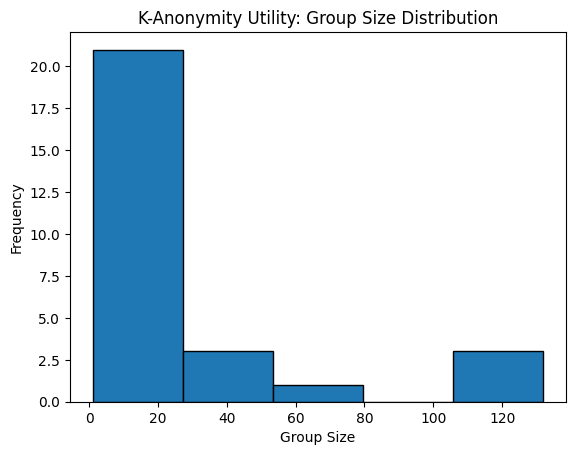

In [37]:
dstsdet_eithout_snonmyzation = titanic6.groupby(quasi_identifiers).size()
plt.hist(k_anonymity_group_sizes, bins=5, edgecolor='black')
plt.title('K-Anonymity Utility: Group Size Distribution')
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.show()

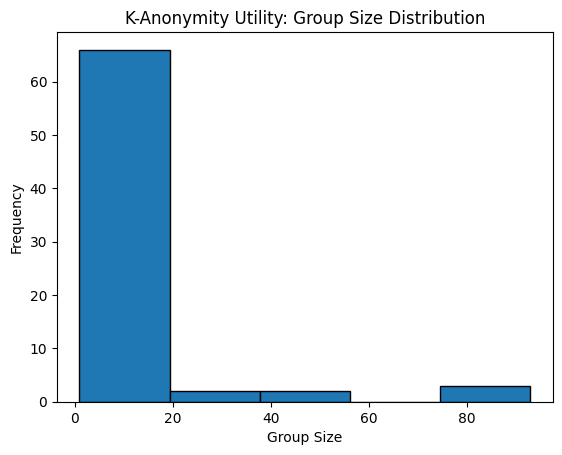

In [43]:
k_anonymity_group_sizes = k_dataset.groupby(quasi_identifiers).size()
plt.hist(k_anonymity_group_sizes, bins=5, edgecolor='black')
plt.title('K-Anonymity Utility: Group Size Distribution')
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.show()

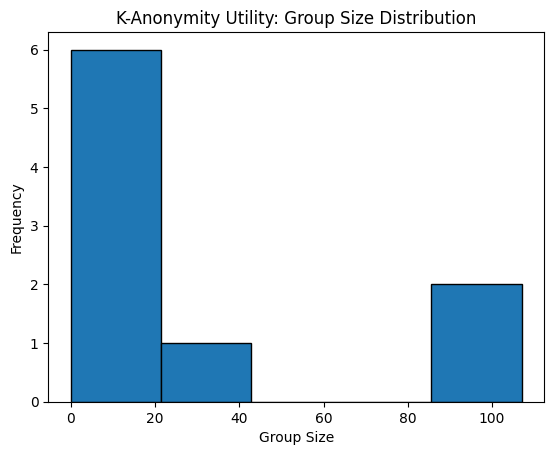

In [44]:
k_anonymity_group_sizes = k_dataset2.groupby(quasi_identifiers).size()
plt.hist(k_anonymity_group_sizes, bins=5, edgecolor='black')
plt.title('K-Anonymity Utility: Group Size Distribution')
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.show()

L-diversity utility

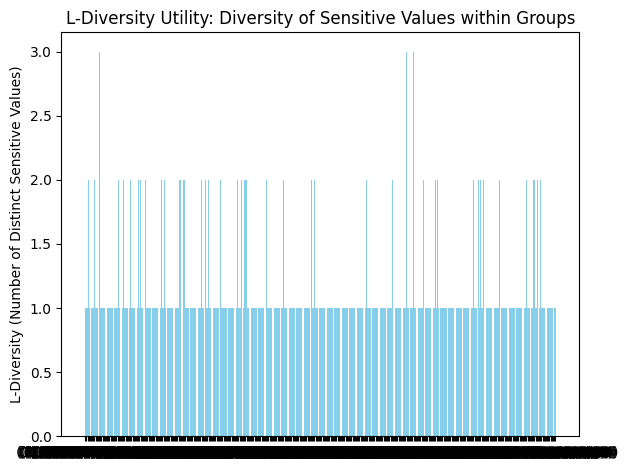

In [56]:
import matplotlib.pyplot as plt
l_diversity_groups = titanic6.groupby(quasi_identifiers)
sensitive_attribute='Parch'

group_names = []
l_diversity_values = []

for group, group_data in l_diversity_groups:
    group_names.append(str(group))
    l_diversity = group_data[sensitive_attribute].nunique()
    l_diversity_values.append(l_diversity)

# Plotting
plt.bar(group_names, l_diversity_values, color='skyblue')
# plt.xlabel('Group (Quasi-Identifiers)')
plt.ylabel('L-Diversity (Number of Distinct Sensitive Values)')
plt.title('L-Diversity Utility: Diversity of Sensitive Values within Groups')
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

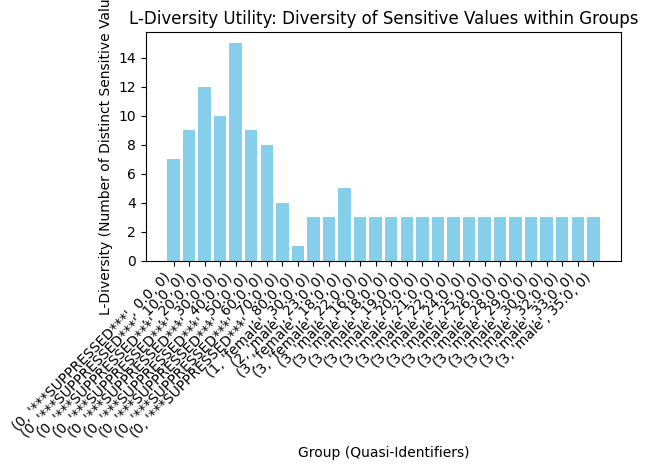

In [51]:
l_diversity_groups = l_dataset.groupby(quasi_identifiers)
sensitive_attribute='Parch'
# Initialize lists to store group names and l-diversity values
group_names = []
l_diversity_values = []

# Analyze L-Diversity Utility: Diversity of Sensitive Values
for group, group_data in l_diversity_groups:
    group_names.append(str(group))

    # Calculate l-diversity (number of distinct sensitive values)
    l_diversity = group_data[sensitive_attribute].nunique()
    l_diversity_values.append(l_diversity)

# Plotting
plt.bar(group_names, l_diversity_values, color='skyblue')
plt.xlabel('Group (Quasi-Identifiers)')
plt.ylabel('L-Diversity (Number of Distinct Sensitive Values)')
plt.title('L-Diversity Utility: Diversity of Sensitive Values within Groups')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

T-closeness

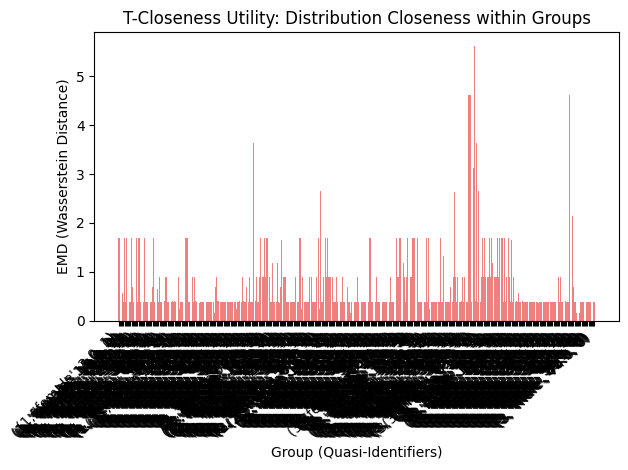

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
t_closeness_groups = titanic6.groupby(quasi_identifiers)

group_names = []
emd_distances = []

overall_distribution = titanic6[sensitive_attribute].value_counts(normalize=True)

for group, group_data in t_closeness_groups:
    group_names.append(str(group))
    group_distribution = group_data[sensitive_attribute].value_counts(normalize=True)
    emd_distance = wasserstein_distance(group_distribution.index, overall_distribution.index,group_distribution.values, overall_distribution.values)
    emd_distances.append(emd_distance)

plt.bar(group_names, emd_distances, color='lightcoral')
plt.xlabel('Group (Quasi-Identifiers)')
plt.ylabel('EMD (Wasserstein Distance)')
plt.title('T-Closeness Utility: Distribution Closeness within Groups')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

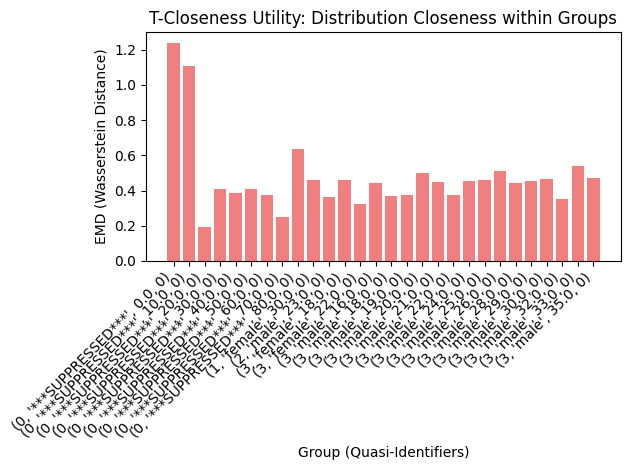

In [59]:

t_closeness_groups = t_dataset.groupby(quasi_identifiers)

group_names = []
emd_distances = []

overall_distribution = t_dataset[sensitive_attribute].value_counts(normalize=True)

for group, group_data in t_closeness_groups:
    group_names.append(str(group))
    group_distribution = group_data[sensitive_attribute].value_counts(normalize=True)
    emd_distance = wasserstein_distance(group_distribution.index, overall_distribution.index,group_distribution.values, overall_distribution.values)
    emd_distances.append(emd_distance)

plt.bar(group_names, emd_distances, color='lightcoral')
plt.xlabel('Group (Quasi-Identifiers)')
plt.ylabel('EMD (Wasserstein Distance)')
plt.title('T-Closeness Utility: Distribution Closeness within Groups')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


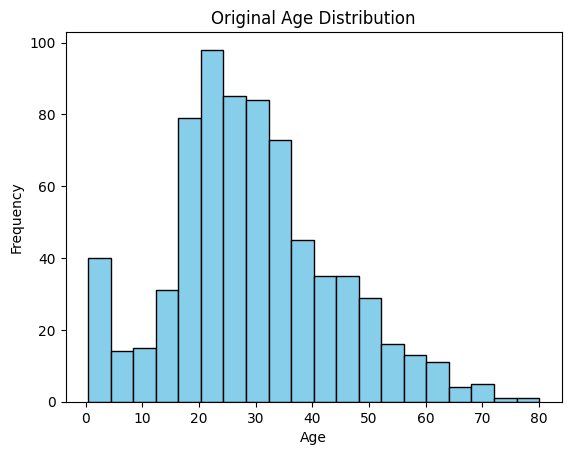

In [69]:
age_data = titanic6[['Age']].dropna()

# Visualize the original distribution
plt.hist(age_data['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

K-means

Silhouette Score: 0.5728285440408735


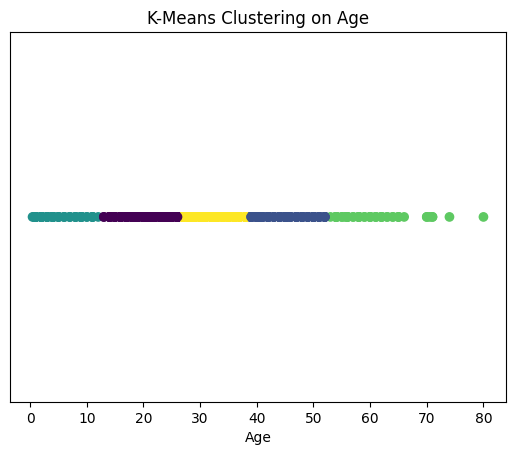

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(selected_data_scaled, selected_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Visualize clusters
plt.scatter(selected_data['Age'], [1] * len(selected_data), c=selected_data['Cluster'], cmap='viridis')
plt.title('K-Means Clustering on Age')
plt.xlabel('Age')
plt.yticks([])  # Hide y-axis
plt.show()

Age
[2.0, 12.4, 22.8, 33.2, 43.6, inf]
Age
[2.0, 14.8, 27.6, 40.400000000000006, 53.2, inf]
Age
[0.75, 14.8, 28.85, 42.900000000000006, 56.95, inf]


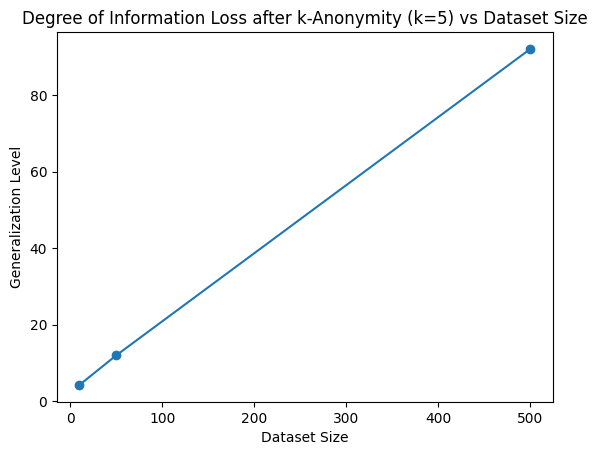

In [77]:
data_sizes=[10,50,500]
generalization_levels = []
def calculate_generalization_level(anonymized_dataset):

    return np.mean(anonymized_dataset.apply(lambda col: len(col.unique())))

for size in data_sizes:
    dataset=pd.read_csv("./titanic.csv",index_col=0).head(size)
    anonymized_dataset = k_anonymity_advanced(dataset,quasi_identifiers,k)
    generalization_level = calculate_generalization_level(anonymized_dataset)
    generalization_levels.append(generalization_level)

# Plotting
plt.plot(data_sizes, generalization_levels, marker='o')
plt.title(f'Degree of Information Loss after k-Anonymity (k={k}) vs Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Generalization Level')
plt.show()

Age
[2.0, 12.4, 22.8, 33.2, 43.6, inf]
Age
[0.83, 14.864, 28.898, 42.932, 56.966, inf]
Age
[0.75, 14.8, 28.85, 42.900000000000006, 56.95, inf]
Age
[0.75, 16.6, 32.45, 48.3, 64.15, inf]


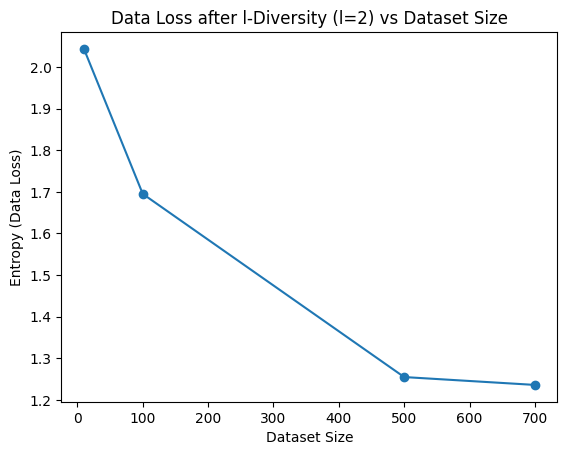

In [84]:
from scipy.stats import entropy
def calculate_entropy(anonymized_dataset, sensitive_attribute):
    values = anonymized_dataset[sensitive_attribute]
    return entropy(values.value_counts(normalize=True))


dataset_sizes = [10, 100, 500, 700]
entropies = []

for size in dataset_sizes:
    dataset=pd.read_csv("./titanic.csv",index_col=0).head(size)
    anonymized_dataset = l_diversity(dataset, quasi_identifiers,'Parch',2)
    entropy_value = calculate_entropy(anonymized_dataset, sensitive_attribute)
    entropies.append(entropy_value)

# Plotting
plt.plot(dataset_sizes, entropies, marker='o')
plt.title(f'Data Loss after l-Diversity (l={2}) vs Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Entropy (Data Loss)')
plt.show()

Age
[2.0, 12.4, 22.8, 33.2, 43.6, inf]
Age
[0.83, 14.864, 28.898, 42.932, 56.966, inf]
Age
[0.75, 14.8, 28.85, 42.900000000000006, 56.95, inf]
Age
[0.75, 16.6, 32.45, 48.3, 64.15, inf]


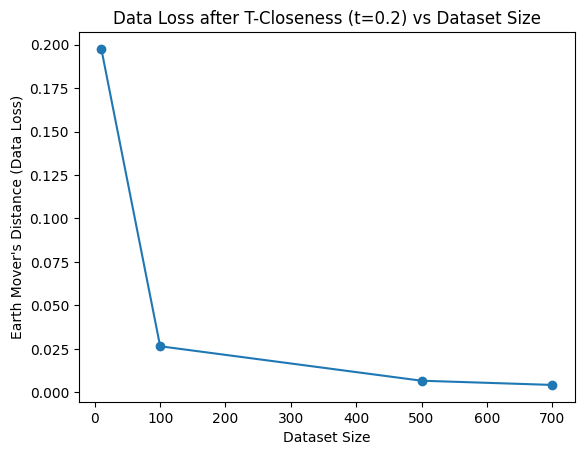

In [88]:
emd_values = []

def calculate_emd(anonymized_dataset, sensitive_attribute):
    # Placeholder for your EMD calculation
    # Replace this with the actual EMD calculation logic
    # Example: Calculate the EMD of the 'SensitiveAttribute' column
    values = anonymized_dataset[sensitive_attribute]
    overall_distribution = values.value_counts(normalize=True)
    group_distribution = anonymized_dataset.groupby('Parch')[sensitive_attribute].value_counts(normalize=True).unstack().fillna(0)

    emd_values = []
    for _, group_dist in group_distribution.iterrows():
        emd = wasserstein_distance(overall_distribution, group_dist)
        emd_values.append(emd)

    return np.mean(emd_values)

for size in dataset_sizes:
    dataset=pd.read_csv("./titanic.csv",index_col=0).head(size)
    anonymized_dataset = T_closeness(dataset, quasi_identifiers,'Parch',0.2)
    emd_value = calculate_emd(anonymized_dataset, 'Parch')
    emd_values.append(emd_value)

plt.plot(dataset_sizes, emd_values, marker='o')
plt.title(f'Data Loss after T-Closeness (t=0.2) vs Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Earth Mover\'s Distance (Data Loss)')
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


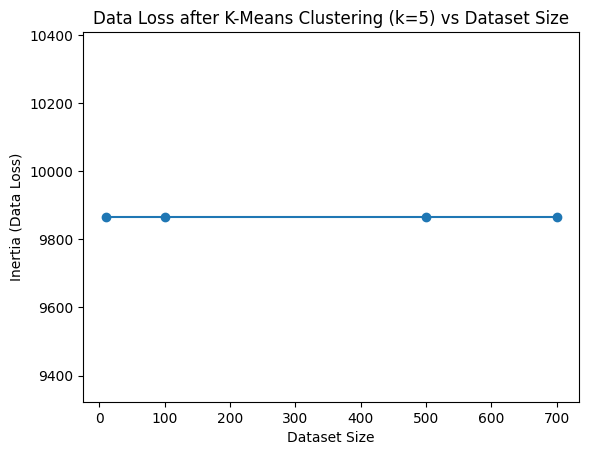

In [93]:
inertia_values = []
def calculate_inertia(anonymized_dataset, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(anonymized_dataset[['Age']])
    return kmeans.inertia_

for size in dataset_sizes:
    dataset=pd.read_csv("./titanic.csv",index_col=0).head(size)
    anonymized_dataset = selected_data
    inertia_value = calculate_inertia(anonymized_dataset, 5)
    inertia_values.append(inertia_value)

plt.plot(dataset_sizes, inertia_values, marker='o')
plt.title(f'Data Loss after K-Means Clustering (k=5) vs Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Inertia (Data Loss)')
plt.show()